# Neural Network Thermometer - Ising 2D Onsager Scale

Given a set of spin configurations, we would like to construct an empirical probability distribution in order to find the most probable temperature value of this set. 

Here we follow the work [Scale-invariant Feature Extraction of Neural Network and Renormalization Group Flow](https://arxiv.org/abs/1801.07172), where a neural network is trained with labeled Monte Carlo Ising configurations, defining a thermometer with temperature scale given by the training set.

Firstly, we load the necessary libraries, including [PyTorch](https://pytorch.org/), a suitable python library for deep learning models.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
torch.manual_seed(12)


from MC_Ising2D import IsingMC
from net import Net
T_c = 2 / ( np.log(1 + np.sqrt(2)) )

## Loading Ising data

The first step is to load the Ising data generated by Monte Carlo procedure. The file `L10_V-RBM.pkl` was constructed considering a square lattice $L\times L$, with $L=10$, and generated 2000 spins configurations for each of 25 different temperatures $ T/J = 10^{-6}, 0.25, 0.5, ..., 5.5, 5.75, 6 $.

In [27]:
ising_data = pd.read_pickle('/home/rodrigo/Dropbox/DOC/RBM_Ising_simple_cases/data/L10_V-RBM_train-test.pkl')
ising_data.head()

,energy,magn,state,temp
0,-36,0,"[0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, ...",6.0
1,-32,8,"[1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, ...",6.0
2,-32,-24,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...",6.0
3,-48,2,"[1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, ...",6.0
4,-36,6,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, ...",6.0


In the thermodynamic limit $( L^2 \rightarrow \infty )$, the isotropic Ising model in a square lattice was analytically solved by [Lars Onsager](https://en.wikipedia.org/wiki/Lars_Onsager) in [1944](https://journals.aps.org/pr/abstract/10.1103/PhysRev.65.117). In this limit, the model show spontaneous magnetization for $ T < T_c$, with $T_c$ given by 

$$ \frac{T_c}{J} = \frac{2}{\log\left(1 + \sqrt{ 2}\right)} \approx 2.269185  \;. $$

With the class `IsingMC` we can check some thermodynamics quantities.

Method fit will construct states to the following temperatures: 
[3.5        3.4        3.3        3.2        3.1        3.
 2.9        2.8        2.7        2.6        2.5        2.4
 2.3        2.27918531 2.26918531 2.25918531 2.2        2.1
 2.         1.9        1.8        1.7        1.6        1.5
 1.4        1.3        1.2        1.1        1.        ]


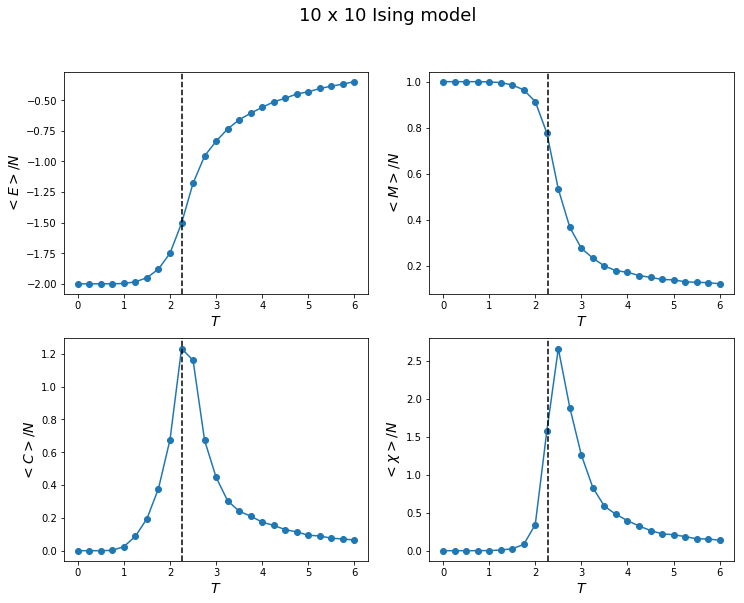

In [28]:
IsingMC(L= 10).plot_thermodynamics(spin_MC= ising_data, Tc_scaled= False)

Since our goal is to measure temperature, the target labels for the samples `ising_data['state']` of our supervised learning must be constructed with the information given by the columns `ising_data['temp']`. 

In [29]:
data = ising_data.drop(columns= ['energy', 'magn'])

## Constructing training and test sets

Using `train_test_split` from [`sklearn`](http://scikit-learn.org/) it is easy to split the data into training and test sets. Since `train_test_split` is a random process and our data has 1000 samples for each of the 29 temperatures values, we split the data for each temperature in order to avoid the possibility of a biased split towards some temperature value.

In [30]:
train_data_ = pd.DataFrame()
test_data_ = pd.DataFrame()

for _, temp in enumerate(data['temp'].value_counts().index.tolist()):
    
    train_data_T, test_data_T = train_test_split(data[data['temp'] == temp],
                                                 test_size= 0.2,
                                                 random_state= 12)
    
    train_data_ = pd.concat([train_data_, train_data_T])
    test_data_ = pd.concat([test_data_, test_data_T])

## One-hot encoding

It is interesting to translate the targets into an [one-hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) structure. 

In [6]:
train_data = pd.get_dummies(train_data_, columns=['temp'])
test_data = pd.get_dummies(test_data_, columns=['temp'])

## Creating a PyTorch dataset

Note that we use a [CUDA tensor type](https://pytorch.org/docs/stable/cuda.html), which implements GPU computation. If a GPU is not available, one should just withdraw the `cuda()` method.

In [7]:
X_train = torch.tensor(list(train_data['state']), dtype= torch.float).cuda()
y_train = torch.tensor(np.array(train_data[list(train_data.columns.values[1:])]), dtype= torch.float).cuda()

X_test = torch.tensor(list(test_data['state']), dtype= torch.float).cuda()
y_test = torch.tensor(np.array(test_data[list(test_data.columns.values[1:])]), dtype= torch.float).cuda()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([40000, 100])
torch.Size([40000, 25])
torch.Size([10000, 100])
torch.Size([10000, 25])


In [8]:
batch_size = 100

train_loader = DataLoader(TensorDataset(X_train, y_train), 
                          batch_size= batch_size, 
                          shuffle= True)

## Training

The neural network is constructed in the class `Net`. Its code is available in the python script `net.py`.

We also have to define the network architecture, optimizer and loss function.

In [9]:
### Defining network architecture

input_size = X_train.shape[1]
out_size = y_train.shape[1]
layers_size = [input_size, 512, 256, 64]


### Initializing the class and defining the number of epochs

net = Net(layers_size, 
          out_size).cuda()     

epochs = 215

print(net)


### Defining optimizer and loss training 

optimizer = optim.SGD(net.parameters(), 
                      lr= 0.1, 
                      weight_decay= 0.0)

loss_func = nn.BCELoss()


### Dictionary to record the results 

log_dic = {
    'epoch': [],
    'loss_train' : [],
    'loss_test' : [],
}


### Training 

for epoch in range(epochs):
    
    t0 = time.time()
    
    loss_epoch = []
    
    ### Loop over mini-batches
       
    for _, (input_data, target) in enumerate(train_loader):
        
        prediction= net(input_data)
        
        loss = loss_func(prediction, target)     
        
        loss_epoch.append(loss.item())
          
        optimizer.zero_grad()   # Clear gradients for the next mini-batches
        loss.backward()         # Backpropagation, compute gradients
        optimizer.step()
               
    ### Recording some results
    log_dic['epoch'].append(epoch)
    log_dic['loss_train'].append(np.mean(loss_epoch))
    test_error_ep = loss_func(net(X_test), y_test).item()
    log_dic['loss_test'].append(test_error_ep)
    t1 = time.time()
    
    ### Training status
    print('Epoch %d, Loss_train= %.10f, Loss_test= %.10f, Time= %.4f' % (epoch, 
                                                                         np.mean(loss_epoch), 
                                                                         test_error_ep, 
                                                                         t1-t0))

Net(
  (layers): ModuleList(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=64, bias=True)
  )
  (out): Linear(in_features=64, out_features=25, bias=True)
)
Epoch 0, Loss_train= 0.1680614189, Loss_test= 0.1679457128, Time= 1.2173
Epoch 1, Loss_train= 0.1678684589, Loss_test= 0.1677841544, Time= 1.0903
Epoch 2, Loss_train= 0.1676905631, Loss_test= 0.1675979793, Time= 1.2951
Epoch 3, Loss_train= 0.1674621061, Loss_test= 0.1673341393, Time= 1.6609
Epoch 4, Loss_train= 0.1671279874, Loss_test= 0.1669327319, Time= 1.8386
Epoch 5, Loss_train= 0.1666183324, Loss_test= 0.1663026959, Time= 1.7442
Epoch 6, Loss_train= 0.1658196050, Loss_test= 0.1653088778, Time= 1.2414
Epoch 7, Loss_train= 0.1645631059, Loss_test= 0.1637550890, Time= 1.0342
Epoch 8, Loss_train= 0.1626176552, Loss_test= 0.1613398492, Time= 1.0518
Epoch 9, Loss_train= 0.1596729686, Loss_test= 0.1578139365, Tim

Epoch 107, Loss_train= 0.1271363583, Loss_test= 0.1276574880, Time= 1.1051
Epoch 108, Loss_train= 0.1270757132, Loss_test= 0.1275905669, Time= 1.0775
Epoch 109, Loss_train= 0.1270954930, Loss_test= 0.1276464462, Time= 0.9652
Epoch 110, Loss_train= 0.1269511666, Loss_test= 0.1278118938, Time= 1.0253
Epoch 111, Loss_train= 0.1268781111, Loss_test= 0.1275166422, Time= 1.0436
Epoch 112, Loss_train= 0.1267991750, Loss_test= 0.1280496866, Time= 1.0501
Epoch 113, Loss_train= 0.1267872092, Loss_test= 0.1272924244, Time= 1.0133
Epoch 114, Loss_train= 0.1266417463, Loss_test= 0.1272251010, Time= 1.0085
Epoch 115, Loss_train= 0.1265495095, Loss_test= 0.1272927970, Time= 1.0445
Epoch 116, Loss_train= 0.1265638935, Loss_test= 0.1271883845, Time= 1.0301
Epoch 117, Loss_train= 0.1265377609, Loss_test= 0.1271874756, Time= 1.0306
Epoch 118, Loss_train= 0.1264588336, Loss_test= 0.1272194684, Time= 1.1166
Epoch 119, Loss_train= 0.1263790025, Loss_test= 0.1275597215, Time= 1.0166
Epoch 120, Loss_train= 0.

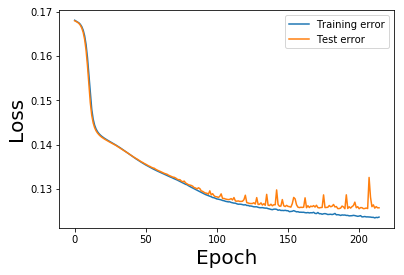

In [10]:
plt.plot(log_dic['epoch'], log_dic['loss_train'], label= 'Training error')
plt.plot(log_dic['epoch'], log_dic['loss_test'], label= 'Test error')
plt.xlabel('Epoch', fontsize= 20)
plt.ylabel('Loss', fontsize= 20)
plt.legend()
plt.show()

### Saving the trained model to a file

In [ ]:
torch.save(net, 'NN_trained_models/L010_NN_Ising2D_MC.pt')

## Measuring temperatures with the trained neural network

As a sanity check, we use the trained neural network to construct the empirical probability temperature distribution for each set of labeled configurations in the test dataset. If the thermometer works fine, the empirical probabilities should be centered around the reference values.

To clean the presentation, we define a suitable plot function.

In [31]:
def thermometer(data,
                T_list,
                errorbar= True,
                x_min= 0, 
                x_max= 6.0,
                calib= False,
                NN_path= 'NN_trained_models/L010_NN_Ising2D_MC.pt'):
    
    net = Net()
    net = torch.load(NN_path) 
    
    calib_curve = []
    temp_ = []
    
    for _, temp in enumerate(T_list):
        
           
        ising_state_temp = data[data['temp'] == temp]['state']
    
        X_ising_test = torch.tensor(list(ising_state_temp), dtype= torch.float).cuda()
    
        prediction= net(X_ising_test)
    
        x_ = np.sort(data['temp'].value_counts().index)
        
        # Calibration curve
        values, indices = torch.max(prediction, 1)
        calib_curve.append(x_[indices])
        temp_.append(temp)
        
        
        if errorbar:
                               
            plt.errorbar(x_,
                         prediction.cpu().mean(dim=0).data.numpy(),
                         yerr= prediction.cpu().std(dim=0).data.numpy(),
                         marker= '.',
                         markersize= 10,
                         linewidth= 0.8,
                         capsize= 5.0,
                         elinewidth= 0.5,
                         markeredgewidth= 0.5,
                         label= 'T = %.6f' % temp )
            
        else:
            
             plt.plot(x_,
                      prediction.cpu().mean(dim=0).data.numpy(),
                      marker= '.',
                      markersize= 10,
                      linewidth= 0.8,
                      label= 'T = %.6f' % temp )
            
    
        plt.axvline(x= temp, linestyle= ':', linewidth= 0.5, color= 'gray')
    
        plt.xlabel('Temperature scale ', fontsize= 15)
        plt.ylabel('Softmax probability', fontsize= 15)
        

    plt.legend(loc= 'center left', bbox_to_anchor=(1, 0.5), fontsize= 'small')
    plt.ylim(0.0, plt.ylim()[1])
    plt.xlim([x_min, x_max])
    plt.show()
    
    if calib:
        return temp_, calib_curve

Defining a list encompassing the temperature scale, we can use the function `thermometer` to plot the empirical probability temperatures.

In [32]:
T_list = test_data_['temp'].value_counts().index.tolist()
T_list.sort()

The dashed lines are the labeled temperature values.

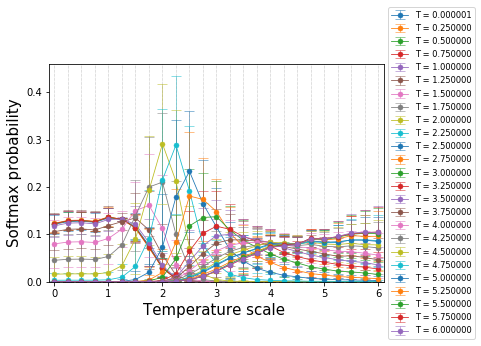

In [33]:
temp_, calib_curve = thermometer(test_data_, 
                                 T_list,
                                 calib= True,
                                 x_min= min(T_list) - 0.1, 
                                 x_max= max(T_list) + 0.1)

We can plot a kind of calibration curve. For convenience, we define the function `calibration_curve`.

In [34]:
def calibration_curve(temp_,
                      calib_curve,
                      L= 10,
                      x_min= 0,
                      x_max= 6,
                      publication= False,
                      save= False, 
                      show= True,
                      grid= True,
                      red_critical= False,
                      Tc_vertical= True,
                      Tc_horizontal= True,
                      scale_step= 1,
                      critical_vl = 2.25):
    
    if red_critical:
        
        temp_c = []
        calib_curve_c = []
        
        temp__ = temp_.copy()
        calib_curve_ = calib_curve.copy()
        
        
        index_critical = np.argwhere(np.array(temp_) == critical_vl)
        index = index_critical[0][0]
        
        temp_c.append(temp_[index])
        calib_curve_c.append(calib_curve[index])
        
        temp__.pop(index)
        calib_curve_.pop(index)
        
      
    if publication:
        plt.figure(figsize=(3.375, 0.678*3.375))
        plt.xticks(fontsize= 6)
        plt.yticks(fontsize= 6)
        markersize = 4.0
        linewidth= 0.4
        fontsize_l = 7.0
        fontsize_t = 8.0
        fontsize_lg= 5.0
        capsize= 2.0   
        elinewidth= 0.2
        markeredgewidth = 0.2
        linewidth_v= 0.4
        linewidth_grid= 0.4
        
    else:
        markersize = 10.0
        linewidth= 0.8
        fontsize_l = 12.0
        fontsize_t = 12.0
        fontsize_lg= 10.0
        capsize= 5.0
        elinewidth= 0.5
        markeredgewidth = 0.5
        linewidth_v= 0.8
        linewidth_grid= 0.6
        
    
    if red_critical:
        
        plt.errorbar(temp__, 
                     np.mean(calib_curve_, axis=1),
                     yerr= np.std(calib_curve_, axis=1),
                     marker= '.',
                     markersize= markersize,
                     linewidth= linewidth,
                     capsize= capsize,
                     elinewidth= elinewidth,
                     markeredgewidth= markeredgewidth)
        
        plt.errorbar(temp_c, 
                     np.mean(calib_curve_c, axis=1),
                     yerr= np.std(calib_curve_c, axis=1),
                     marker= '.',
                     markersize= markersize,
                     linewidth= linewidth,
                     capsize= capsize,
                     elinewidth= elinewidth,
                     markeredgewidth= markeredgewidth,
                     color= 'C3')
        
        color_yx= 'C2'

        
    else:
        
               
        plt.errorbar(temp_, 
                     np.mean(calib_curve, axis=1),
                     yerr= np.std(calib_curve, axis=1),
                     marker= '.',
                     markersize= markersize,
                     linewidth= linewidth,
                     capsize= capsize,
                     elinewidth= elinewidth,
                     markeredgewidth= markeredgewidth)
            
        color_yx= 'C1'
        
            
    plt.xlabel('$T_{mc}$', fontsize= fontsize_l)
    plt.ylabel('$T_{nn}$', fontsize= fontsize_l)
    
    if Tc_vertical:
        
        if red_critical:
            color_Tc= 'C3'
        else:
            color_Tc= 'black'
            
        plt.axvline(x= T_c, linestyle= ':', linewidth= linewidth_v, color= color_Tc)
    
    
    if Tc_horizontal:
        
        if red_critical:
            color_Tc= 'C3'
        else:
            color_Tc= 'black'
            
        plt.axhline(y= T_c, linestyle= ':', linewidth= linewidth_v, color= color_Tc)
            
      
    start= plt.xlim()[0]
    end= plt.xlim()[1]
      
    plt.ylim(start, end)
    plt.xlim(start, end)
    
    
    plt.xticks(np.arange(x_min, x_max+ scale_step, scale_step))
    plt.yticks(np.arange(x_min, x_max+ scale_step, scale_step))
    
    plt.grid(b= grid,
             linewidth= linewidth_grid,
             linestyle= ':')
    
    if save:
        if publication:
            path_fig = 'figures/PUB_CALIB_THERM_L%d_Onsager.pdf' % L
            plt.savefig(path_fig , bbox_inches='tight')
        else:
            path_fig = 'figures/CALIB_THERM_L%d_Onsager.pdf' % L
            plt.savefig(path_fig, bbox_inches='tight')
            
    if show:
        plt.show()

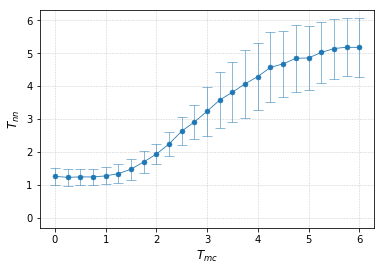

In [10]:
calibration_curve(temp_,
                  calib_curve,
                  L= 10,
                  x_min= 0,
                  x_max= 6,
                  publication= False,
                  save= False,
                  red_critical= False,
                  Tc_vertical= False,
                  Tc_horizontal= False,
                  scale_step= 1,
                  critical_vl = 2.25)

The fact that the thermometer would indicate a flow towards critical temperature if the measure is in the interval $2.25 \pm 0.36$ is crucial to our argument that a wide range of magnetization values of the RBM fixed point would be identified by the thermometer as a flow towards $T_c$.

The behavior of the thermometer is quite similar to the one in the paper [Scale-invariant Feature Extraction of Neural Network and Renormalization Group Flow](https://arxiv.org/abs/1801.07172). It is difficult to distinguish low and high temperatures values, while the peaks around the critical temperature of this scale are evident.

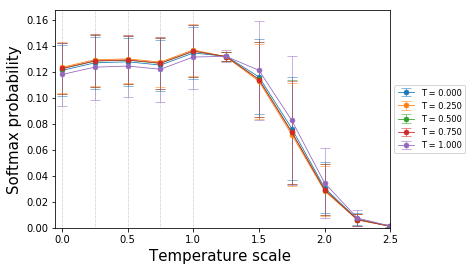

In [18]:
thermometer(test_data_, 
            T_list[:5],
            x_min= min(T_list[:5]) - 0.05, x_max= 2.5)

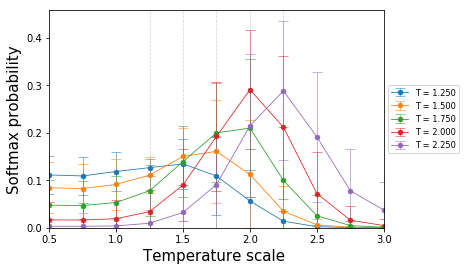

In [19]:
thermometer(test_data_, 
            T_list[5:10],
            x_min= 0.5, x_max= 3.0)

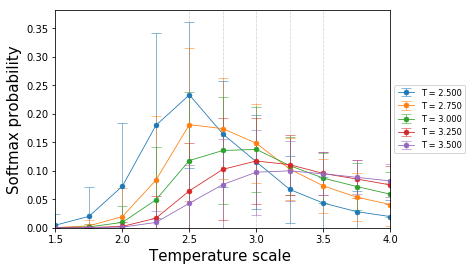

In [20]:
thermometer(test_data_, 
            T_list[10:15],
            x_min= 1.5, x_max= 4)

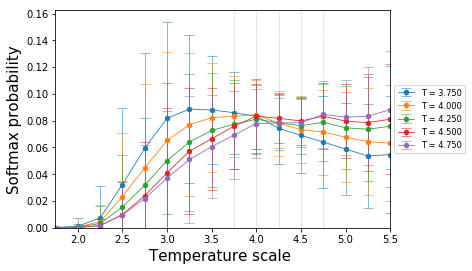

In [21]:
thermometer(test_data_, 
            T_list[15:20],
            x_min= 1.75, x_max= 5.5)

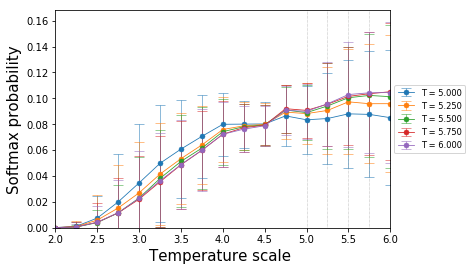

In [22]:
thermometer(test_data_, 
            T_list[20:25],
            x_min= 2.0, x_max= 6.0)

## Error in the temperature measure near $T_c$ in the magnetization point of view

In this section we analyze the standard deviation of the thermometer measure near $T_c$ from the magnetization point of view. That is, how the magnetization, which can be measured directly from the visible layers of the RBM, varies within the uncertainty interval defined by thermometer. 

We calculate the standard deviation near critical temperature.

In [35]:
index_critical = np.argwhere(np.array(temp_) == 2.25)
index = index_critical[0][0]

In [36]:
temp_c = temp_[index]
std__c = np.std(calib_curve, axis=1)[index]

print(temp_c)
print(std__c)

2.25
0.36111318776112294


The fact that the thermometer would indicate a flow towards critical temperature if the measure is in the interval $2.25 \pm 0.36$ is crucial to our argument that a wide range of magnetization values of the RBM fixed point would be identified by the thermometer as a flow towards $T_c$.

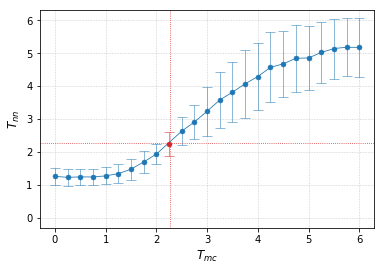

In [14]:
calibration_curve(temp_,
                  calib_curve,
                  L= 10,
                  x_min= 0,
                  x_max= 6,
                  publication= False,
                  save= False,
                  red_critical= True,
                  grid= True,
                  Tc_vertical= True,
                  Tc_horizontal= True,
                  scale_step= 1,
                  critical_vl = temp_c)

The figure above was selected for publication, then (to set the predefined pattern) we run again the function `calibration_curve` with `publication= True`.

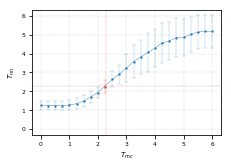

In [15]:
calibration_curve(temp_,
                  calib_curve,
                  L= 10,
                  x_min= 0,
                  x_max= 6,
                  publication= True,
                  save= False,
                  red_critical= True,
                  grid= True,
                  Tc_vertical= True,
                  Tc_horizontal= True,
                  scale_step= 1,
                  critical_vl = temp_c)

The functions below are conveniently constructed for the purpose of plotting the magnetization with a colored area related to the standard deviation of the thermometer near $T_c$.

In [41]:
def mag_computation(L,
                    spin_MC,
                    Tc_scaled= False):
    
    T_c = 2 / ( np.log(1 + np.sqrt(2)) )
    N_spins = L*L
    
    if Tc_scaled:
        spin_MC['temp_'] = spin_MC['temp'] / T_c
        
    else:
        spin_MC['temp_'] = spin_MC['temp'] 
               
    expec_val_per_spin_MAGN = abs(spin_MC['magn']).groupby(spin_MC['temp_']).mean() / N_spins
    
    return expec_val_per_spin_MAGN



def mag_plot_std(L, 
                 spin_MC,
                 temp_c, 
                 std__c,
                 num_std= 1,
                 y_horiz= 0.65068,
                 y_dashed= False,
                 Tc_scaled= False, 
                 save= False, 
                 publication= False,
                 show= True,
                 inset= False):
    
    T_c = 2 / ( np.log(1 + np.sqrt(2)) )
    
    if publication:
        if inset:
            #plt.xticks(fontsize= 16)
            #plt.yticks(fontsize= 16)
            markersize = 0.45
            linewidth= 0.2
            fontsize_l = 7.0
            fontsize_t = 3.0
            fontsize_lg= 3.0
            linewidth_v = 0.15
            color = 'C0'
            color_e = 'C3'
            path_fig = 'figures/PUB_MAG_MC_near_Tc_L%d_std%d_inset.pdf' % (L, num_std)

        else:
            plt.figure(figsize=(3.375, 0.678*3.375))
            plt.xticks(fontsize= 6)
            plt.yticks(fontsize= 6)
            markersize = 1.5
            linewidth= 0.4
            fontsize_l = 7.0
            fontsize_t = 8.0
            fontsize_lg= 5.0
            linewidth_v = 0.5
            color = 'C0'
            color_e = 'C3'
            path_fig = 'figures/PUB_MAG_MC_near_Tc_L%d_std%d.pdf' % (L, num_std)
            
    
    else:
        if inset:
            path_fig = 'figures/MAG_MC_near_Tc_L%d_std%d_inset.pdf' %  (L, num_std)
            markersize= 1.5
            linewidth= 0.4
            fontsize_l= 6.0
            fontsize_t= 5.0
            fontsize_lg= 5.0
            linewidth_v = 0.5
            color = 'C0'
            color_e = 'C3'
        else:
            path_fig = 'figures/MAG_MC_near_Tc_L%d_std%d.pdf' %  (L, num_std)
            markersize= 5.0
            linewidth= 0.8
            fontsize_l= 12.0
            fontsize_t= 12.0
            fontsize_lg= 10.0
            linewidth_v = 1.0
            color = 'C0'
            color_e = 'C3'
        
    magn = mag_computation(L= L, 
                           spin_MC= spin_MC,
                           Tc_scaled= Tc_scaled)
        
    plt.plot(magn, 
             '-o',
             label= 'L = %d' % L,
             color= color, 
             markersize= markersize,
             linewidth= linewidth)
    
    if Tc_scaled:
        z1 = (temp_c + num_std*std__c)/temp_c
        z2 = (temp_c - num_std*std__c)/temp_c
        dashed_v = 1.0
    else:
        z1 = temp_c + num_std*std__c
        z2 = temp_c - num_std*std__c
        dashed_v = T_c
    
    plt.axvline(x= dashed_v, linestyle= ':', linewidth= linewidth_v, color= color_e)
    
    plt.axvline(x= z1, linestyle= ':', linewidth= linewidth_v, color= color_e)
    plt.axvline(x= z2, linestyle= ':', linewidth= linewidth_v, color= color_e)
    
    if y_dashed:
        plt.axhline(y= y_horiz, linestyle= ':', linewidth= linewidth_v, color= 'black')
      
    plt.axvspan(z1, z2, alpha=0.075, color= color_e)
    
    plt.tick_params(axis='both', labelsize= fontsize_t)
    
    
    if not inset:
        plt.ylabel('$<M>/N$', fontsize= fontsize_l)
        plt.legend(fontsize= fontsize_lg)
        if Tc_scaled:
            plt.xlabel('$T / T_c$', fontsize= fontsize_l)
        else:
            plt.xlabel('$T$', fontsize= fontsize_l)
            
    else:
        plt.legend(fontsize= fontsize_lg)
            
    if save:
        plt.savefig(path_fig , bbox_inches='tight')
        
    if show:
        plt.show()

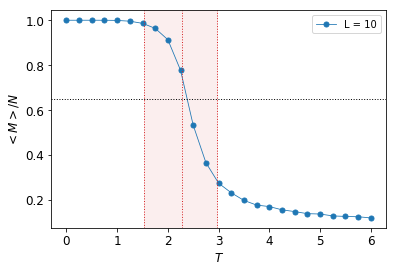

In [43]:
mag_plot_std(L= 10, 
             spin_MC= ising_data, 
             Tc_scaled= False, 
             temp_c= temp_c, 
             std__c= std__c,
             num_std= 2,
             y_horiz= 0.65068,
             y_dashed= True,
             save= False, 
             publication= False)

The figure above was selected for publication, then (to set the predefined pattern) we run again the `mag_plot_std` function with `publication= True`.

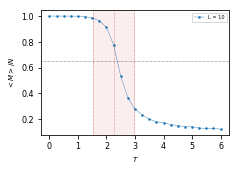

In [44]:
mag_plot_std(L= 10, 
             spin_MC= ising_data, 
             Tc_scaled= False, 
             temp_c= temp_c, 
             std__c= std__c,
             num_std= 2,
             y_horiz= 0.65068,
             y_dashed= True,
             save= False, 
             publication= True)

### Magnetization plot as an inset in calibration curve plot

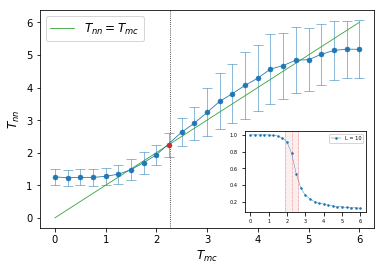

In [72]:
publication= False
save= False
L = 10


if publication:
    plt.figure(figsize= (3.375, 0.678*3.375))
    if save:
        path_file = 'figures/PUB_CALIB_THERM_L%d_Onsager_INSET.pdf' % L
        
else:
    if save:
        path_file = 'figures/CALIB_THERM_L%d_Onsager_INSET.pdf' % L
        
        


calibration_curve(temp_,
                  calib_curve,
                  L= 10,
                  x_min= 0,
                  x_max= 6,
                  publication= False,
                  save= False,
                  show= False,
                  red_critical= True,
                  critical_vl = temp_c)

a = plt.axes([0.6, 0.18, 0.28, 0.28])


mag_plot_std(L= 10, 
             spin_MC= ising_data, 
             Tc_scaled= False, 
             temp_c= temp_c, 
             std__c= std__c,
             save= False, 
             publication= False,
             show= False, 
             inset= True)

if save:
    plt.savefig(path_file, bbox_inches='tight')

plt.show()

The figure above was selected for publication, then (to set the predefined pattern) we run again the cellwith `publication= True`.

<Figure size 243x164.754 with 0 Axes>

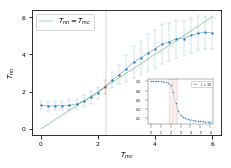

In [73]:
publication= True
save= False
L = 10


if publication:
    plt.figure(figsize= (3.375, 0.678*3.375))
    if save:
        path_file = 'figures/PUB_CALIB_THERM_L%d_Onsager_INSET.pdf' % L
        
else:
    if save:
        path_file = 'figures/CALIB_THERM_L%d_Onsager_INSET.pdf' % L
        
        


calibration_curve(temp_,
                  calib_curve,
                  L= 10,
                  x_min= 0,
                  x_max= 6,
                  publication= True,
                  save= False,
                  show= False,
                  red_critical= True,
                  critical_vl = temp_c)

a = plt.axes([0.6, 0.19, 0.27, 0.27])

for axis in ['top','bottom','left','right']:
    a.spines[axis].set_linewidth(0.3)
    
a.tick_params(axis="x", labelsize= 7.0, width= 0.3)
a.tick_params(axis="y", labelsize= 7.0, width= 0.3)


mag_plot_std(L= 10, 
             spin_MC= ising_data, 
             Tc_scaled= False, 
             temp_c= temp_c, 
             std__c= std__c,
             save= False, 
             publication= True,
             show= False, 
             inset= True)

if save:
    plt.savefig(path_file, bbox_inches='tight')

plt.show()